In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

# Load a single RGB image
image_path = 'Image(300).jpg'
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(64, 64))
x_train_rgb = tf.keras.preprocessing.image.img_to_array(image)
x_train_rgb = np.expand_dims(x_train_rgb, axis=0)

# Normalize pixel values to the range [-1, 1]
x_train_rgb = (x_train_rgb.astype(np.float32) - 127.5) / 127.5

In [ ]:
#  generator model for RGB images
def build_rgb_generator(latent_dim):
    model = models.Sequential()
    model.add(layers.Dense(256, input_dim=latent_dim, activation='relu'))
    model.add(layers.Dense(3 * 64 * 64, activation='tanh'))  # Adjust output dimensions
    model.add(layers.Reshape((64, 64, 3)))
    return model

In [ ]:
#  discriminator model for RGB images
def build_rgb_discriminator(img_shape):
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=img_shape))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [ ]:
# Build and compile the discriminator
img_shape_rgb = (64, 64, 3)
discriminator_rgb = build_rgb_discriminator(img_shape_rgb)
discriminator_rgb.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Build the generator
latent_dim_rgb = 100
generator_rgb = build_rgb_generator(latent_dim_rgb)

In [ ]:
# Combined model (stacked generator and discriminator)
discriminator_rgb.trainable = False
gan_input_rgb = tf.keras.Input(shape=(latent_dim_rgb,))
generated_img_rgb = generator_rgb(gan_input_rgb)
gan_output_rgb = discriminator_rgb(generated_img_rgb)

gan_rgb = tf.keras.Model(gan_input_rgb, gan_output_rgb)
gan_rgb.compile(loss='binary_crossentropy', optimizer='adam')

In [ ]:
def train_gan_rgb(epochs=1, batch_size=1):
    batch_count = x_train_rgb.shape[0] // batch_size

    for e in range(epochs):
        for _ in range(batch_count):
            noise = np.random.normal(0, 1, size=(batch_size, latent_dim_rgb))
            generated_images = generator_rgb.predict(noise)

            image_batch = x_train_rgb

            X = np.concatenate([image_batch, generated_images])
            y_dis = np.zeros(2 * batch_size)
            y_dis[:batch_size] = 0.9  # Label smoothing

            discriminator_rgb.trainable = True
            d_loss = discriminator_rgb.train_on_batch(X, y_dis)

            noise = np.random.normal(0, 1, size=(batch_size, latent_dim_rgb))
            y_gen = np.ones(batch_size)
            discriminator_rgb.trainable = False
            g_loss = gan_rgb.train_on_batch(noise, y_gen)

        print(f"Epoch {e}/{epochs} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")

In [ ]:
train_gan_rgb(epochs = 3000, batch_size=1)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 17ms/step
Epoch 500/3000 [D loss: 0.2669908106327057 | D accuracy: 50.0] [G loss: 25.078516006469727]
1/1 [==============================] - 0s 18ms/step
Epoch 501/3000 [D loss: 0.22775273025035858 | D accuracy: 50.0] [G loss: 10.228734016418457]
1/1 [==============================] - 0s 17ms/step
Epoch 502/3000 [D loss: 0.16401317715644836 | D accuracy: 50.0] [G loss: 10.492588996887207]
1/1 [==============================] - 0s 20ms/step
Epoch 503/3000 [D loss: 0.17579014599323273 | D accuracy: 50.0] [G loss: 9.741597175598145]
1/1 [==============================] - 0s 17ms/step
Epoch 504/3000 [D loss: 0.21505582332611084 | D accuracy: 50.0] [G loss: 10.071452140808105]
1/1 [==============================] - 0s 20ms/step
Epoch 505/3000 [D loss: 0.2058146595954895 | D accuracy: 50.0] [G loss: 0.05754455178976059]
1/1 [==============================] - 0s 17ms/step
Epoch 506/3000 [D loss: 0.199

1/1 [==============================] - 0s 88ms/step


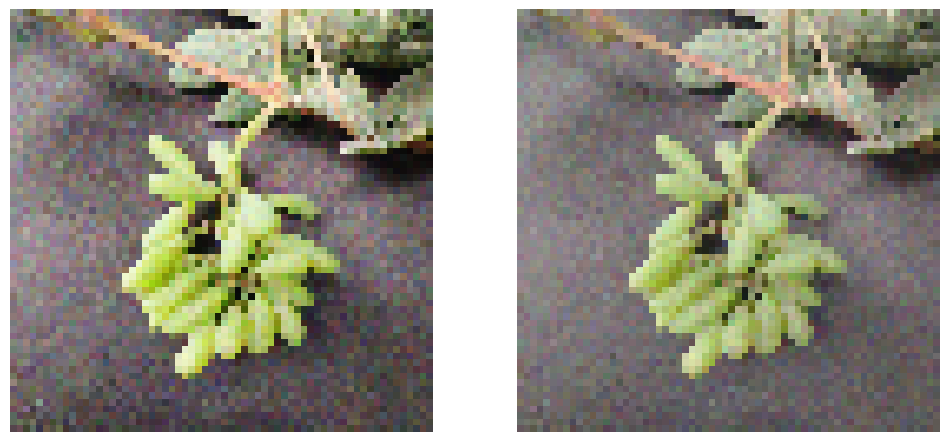

In [ ]:
import matplotlib.pyplot as plt

# Generate new samples using the trained generator
num_samples = 2 # Adjust as needed
noise = np.random.normal(0, 1, size=(num_samples, latent_dim_rgb))
generated_images = generator_rgb.predict(noise)

# Denormalize pixel values to the range [0, 1] for visualization
generated_images = 0.5 * generated_images + 0.5

# Visualize the generated images
fig, axs = plt.subplots(1,num_samples , figsize=(12, 15))
for i in range(num_samples):
    axs[i].imshow(generated_images[i])
    axs[i].axis('off')
plt.show()